In [22]:
"""
Clinic Setup Project (CPM + PRA + Z3)

Problem definition:
We want to plan and schedule the setup of a small medical clinic.
The project includes selecting a location, obtaining permits, renovating the clinic,
purchasing and installing medical equipment, setting up IT/network systems,
recruiting and training staff, testing, final inspection, and opening.

Goal:
1) CPM: compute ES/EF/LS/LF/Float, identify critical path, and compute drag.
2) PRA: model uncertainty in durations via Monte Carlo simulation, estimate mean & 95th percentile.
3) Z3: optimize the schedule (minimize makespan) under precedence constraints.
"""

from dataclasses import dataclass   #tools for defining data structures
from typing import Dict, Tuple   #tools for defining data structures
import random  #tools for generating random numbers
import statistics  #tools for statistical calculations

import networkx as nx   #tools for drwawing and analyzing graphs
import matplotlib.pyplot as plt #tools for plotting

from z3 import Int, Optimize, If, Or, Sum, sat  #tools for optimization


In [23]:
#ok
def z3_max(values):
    """Safe max for Z3 Int/Arith expressions using If-chain."""
    assert len(values) > 0
    m = values[0]
    for v in values[1:]:
        m = If(v > m, v, m)
    return m

In [24]:
#ok
@dataclass(frozen=True)
class Task:
    name: str
    duration: float
    predecessors: Tuple[str, ...] = ()


In [25]:
#ok (11 tasks)
clinic_tasks = {
    "A": Task("A", 3, ()),             # Location selection
    "B": Task("B", 5, ("A",)),         # Legal permits
    "C": Task("C", 10, ("B",)),        # Interior renovation
    "D": Task("D", 7, ("B",)),         # Medical equipment purchase
    "E": Task("E", 4, ("C",)),         # IT & network setup
    "F": Task("F", 8, ("B",)),         # Staff recruitment
    "G": Task("G", 3, ("D",)),         # Equipment installation
    "H": Task("H", 5, ("F",)),         # Staff training
    "I": Task("I", 3, ("E", "G")),     # System testing
    "J": Task("J", 2, ("H", "I")),     # Final inspection
    "K": Task("K", 1, ("J",)),         # Clinic opening
}

clinic_activity_desc = {
    "A": "Location selection",
    "B": "Legal permits",
    "C": "Interior renovation",
    "D": "Medical equipment purchase",
    "E": "IT & network setup",
    "F": "Staff recruitment",
    "G": "Equipment installation",
    "H": "Staff training",
    "I": "System testing",
    "J": "Final inspection",
    "K": "Clinic opening",
}


In [26]:
#ok (statistical sigmas for PRA)
clinic_sigmas = {
    "A": 0.6,   # location can vary
    "B": 1.5,   # permits can be unpredictable
    "C": 3.0,   # renovation often high uncertainty
    "D": 2.0,   # equipment delivery delays
    "E": 1.0,   # IT setup medium
    "F": 2.0,   # recruitment can vary
    "G": 1.0,   # installation medium
    "H": 1.0,   # training medium
    "I": 1.0,   # testing medium
    "J": 0.8,   # inspection small-medium
    "K": 0.0,   # opening milestone fixed
}


In [27]:
#ok
def topological_order(tasks: Dict[str, Task]):
    indeg = {t: 0 for t in tasks}
    succ = {t: [] for t in tasks}

    for t, obj in tasks.items():
        for p in obj.predecessors:
            succ[p].append(t)
            indeg[t] += 1

    q = [t for t in tasks if indeg[t] == 0]
    order = []

    while q:
        n = q.pop(0)
        order.append(n)
        for s in succ[n]:
            indeg[s] -= 1
            if indeg[s] == 0:
                q.append(s)

    return order


In [28]:
#ok
def cpm(tasks: Dict[str, Task]):
    order = topological_order(tasks)
    ES, EF, LS, LF = {}, {}, {}, {}

    # Forward pass==>>ES, EF
    for t in order:
        ES[t] = max([EF[p] for p in tasks[t].predecessors], default=0)
        EF[t] = ES[t] + tasks[t].duration

    project_duration = max(EF.values())

    # Backward pass==>>LS, LF
    for t in reversed(order):
        successors = [s for s in tasks if t in tasks[s].predecessors]
        LF[t] = min([LS[s] for s in successors], default=project_duration)
        LS[t] = LF[t] - tasks[t].duration

    TF = {t: LS[t] - ES[t] for t in tasks}

    return ES, EF, LS, LF, TF, project_duration


In [29]:
#ok
def compute_drag(tasks: Dict[str, Task], base_project_duration):
    drags = {}
    for t in tasks:
        modified = dict(tasks)
        modified[t] = Task(t, 0, tasks[t].predecessors)
        ES2, EF2, LS2, LF2, TF2, dur2 = cpm(modified)
        drags[t] = base_project_duration - dur2
    return drags


In [30]:
#ok
ES, EF, LS, LF, TF, project_duration = cpm(clinic_tasks)

print("Project Duration:", project_duration, "days\n")
print("Task | ES | EF | LS | LF | Float | Critical")
print("-"*45)

for t in topological_order(clinic_tasks):
    print(f"{t:>4} | {ES[t]:>2} | {EF[t]:>2} | {LS[t]:>2} | {LF[t]:>2} | {TF[t]:>5} | {'YES' if TF[t]==0 else 'NO'}")

Project Duration: 28 days

Task | ES | EF | LS | LF | Float | Critical
---------------------------------------------
   A |  0 |  3 |  0 |  3 |     0 | YES
   B |  3 |  8 |  3 |  8 |     0 | YES
   C |  8 | 18 |  8 | 18 |     0 | YES
   D |  8 | 15 | 12 | 19 |     4 | NO
   F |  8 | 16 | 12 | 20 |     4 | NO
   E | 18 | 22 | 18 | 22 |     0 | YES
   G | 15 | 18 | 19 | 22 |     4 | NO
   H | 16 | 21 | 20 | 25 |     4 | NO
   I | 22 | 25 | 22 | 25 |     0 | YES
   J | 25 | 27 | 25 | 27 |     0 | YES
   K | 27 | 28 | 27 | 28 |     0 | YES


In [31]:
#ok
clinic_critical_path = [t for t in topological_order(clinic_tasks) if TF[t] == 0]
print("Clinic Critical Path:")
print(" → ".join(clinic_critical_path))


Clinic Critical Path:
A → B → C → E → I → J → K


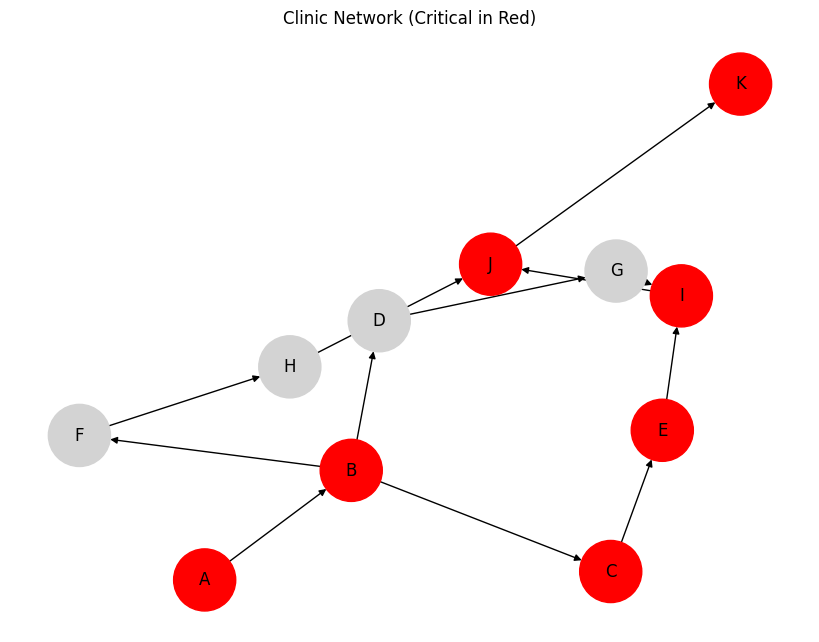

In [32]:
#ok
G = nx.DiGraph()
for t, obj in clinic_tasks.items():
    G.add_node(t)
    for p in obj.predecessors:
        G.add_edge(p, t)

colors = ["red" if TF[n] == 0 else "lightgray" for n in G.nodes()]
pos = nx.spring_layout(G, seed=1)

plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000)
plt.title("Clinic Network (Critical in Red)")
plt.show()


In [33]:
#ok
def sample_duration(mu, sigma):
    if sigma == 0:
        return int(mu)
    return max(1, int(round(random.gauss(mu, sigma))))


In [34]:
#ok
mc_durations = []
mc_critical_count = {t: 0 for t in clinic_tasks}

N = 1000
random.seed(42)

for _ in range(N):
    sampled_tasks = {
        t: Task(t, sample_duration(clinic_tasks[t].duration, clinic_sigmas[t]), clinic_tasks[t].predecessors)
        for t in clinic_tasks
    }

    _, _, _, _, TF_s, dur = cpm(sampled_tasks)
    mc_durations.append(dur)

    for t in sampled_tasks:
        if TF_s[t] == 0:
            mc_critical_count[t] += 1


PRA Mean Duration: 28.41
PRA 95th Percentile: 34

Critical Frequency (%):
A (Location selection): 100.0%
B (Legal permits): 100.0%
J (Final inspection): 100.0%
K (Clinic opening): 100.0%
I (System testing): 89.9%
C (Interior renovation): 80.6%
E (IT & network setup): 80.6%
F (Staff recruitment): 16.4%
H (Staff training): 16.4%
D (Medical equipment purchase): 14.4%
G (Equipment installation): 14.4%


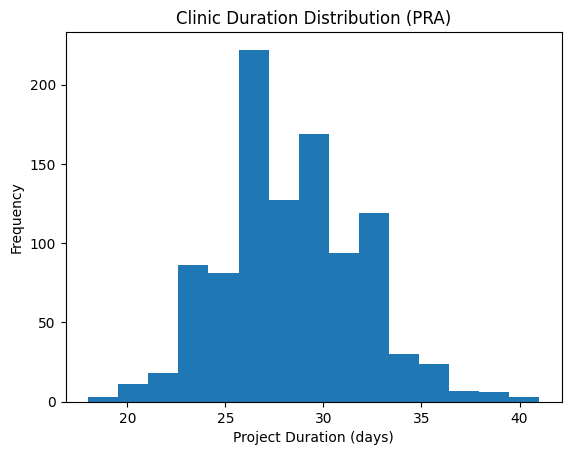

In [35]:
mc_mean = round(statistics.mean(mc_durations), 2)
mc_p95 = sorted(mc_durations)[int(0.95 * N)]

print("PRA Mean Duration:", mc_mean)
print("PRA 95th Percentile:", mc_p95)

print("\nCritical Frequency (%):")
for t in sorted(mc_critical_count, key=mc_critical_count.get, reverse=True):
    print(f"{t} ({clinic_activity_desc[t]}): {100*mc_critical_count[t]/N:.1f}%")

plt.hist(mc_durations, bins=15)
plt.xlabel("Project Duration (days)")
plt.ylabel("Frequency")
plt.title("Clinic Duration Distribution (PRA)")
plt.show()


In [36]:
def plot_gantt_with_metrics(tasks, ES, EF, LS, LF, TF, drags, title="Gantt Chart with Critical Path Highlighted"):
    order = list(reversed(topological_order(clinic_tasks)))  # Up to down
    plt.figure(figsize=(13, 7))

    for i, t in enumerate(order):
        y = i
        start_es = ES[t]
        dur = tasks[t].duration

        is_critical = (TF[t] == 0)
        
        
        color = None  # default color
        if is_critical:
            color = "tab:red"
        else:
            color = "tab:blue"

        plt.barh(y, dur, left=start_es, height=0.6, color=color, alpha=0.6, edgecolor="black")

        
        plt.text(start_es - 0.2, y + 0.12, f"ES: {ES[t]}", ha="right", va="center", fontsize=9)
        plt.text(start_es - 0.2, y - 0.12, f"LS: {LS[t]}", ha="right", va="center", fontsize=9)

        #Righthand EF and LF
        plt.text(EF[t] + 0.2, y + 0.12, f"EF: {EF[t]}", ha="left", va="center", fontsize=9)
        plt.text(EF[t] + 0.2, y - 0.12, f"LF: {LF[t]}", ha="left", va="center", fontsize=9)

        #  Drag and Float
        
        plt.text(start_es + dur * 0.65, y + 0.35, f"Drag: {int(round(drags[t]))}", fontsize=9, ha="center")
        plt.text(start_es + dur * 0.65, y + 0.10, f"Float: {int(round(TF[t]))}", fontsize=9, ha="center")

        # labels on the left: task names
        plt.text(-0.5, y, t, ha="right", va="center", fontsize=11, fontweight="bold")

    plt.yticks(range(len(order)), [""] * len(order))  # since I manually wrote task names
    plt.xlabel("Time")
    plt.ylabel("Activities")
    plt.title(title)
    plt.grid(True, axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()



A (Location selection)
B (Legal permits)
J (Final inspection)
K (Clinic opening)
I (System testing)
C (Interior renovation)
E (IT & network setup)
F (Staff recruitment)
H (Staff training)
D (Medical equipment purchase)
G (Equipment installation)


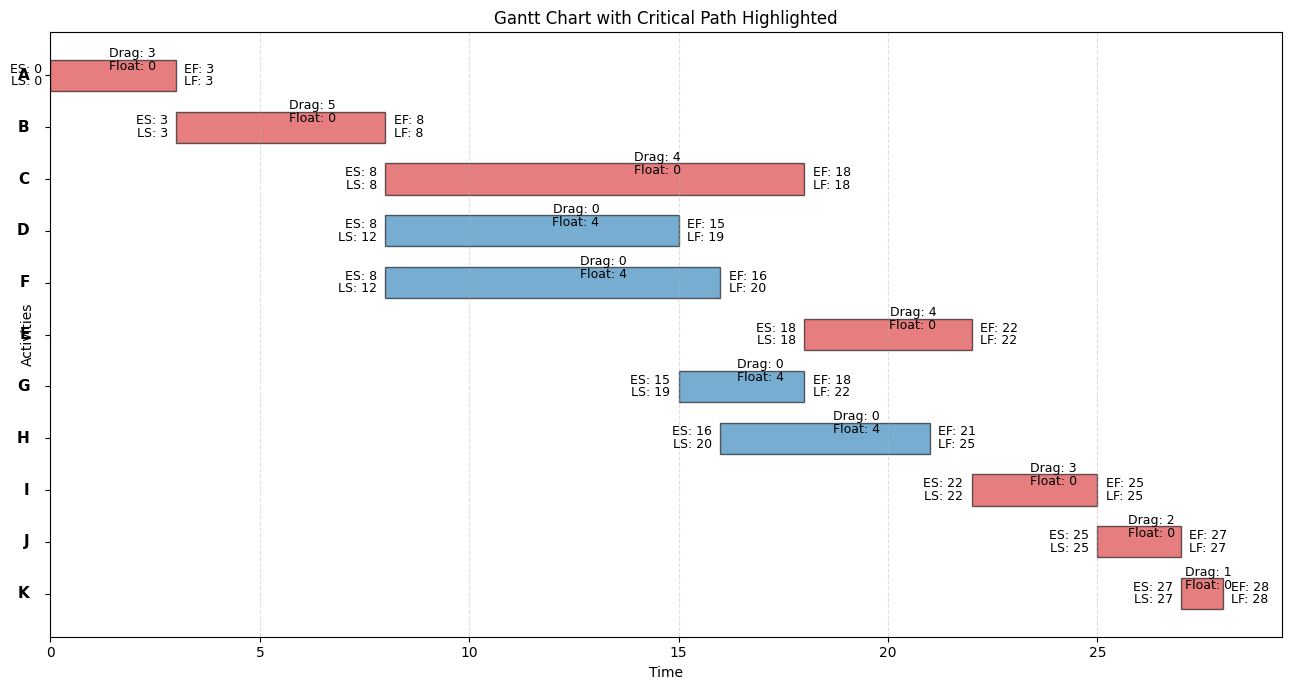

In [37]:
ES, EF, LS, LF, TF, project_duration = cpm(clinic_tasks)
drags = compute_drag(clinic_tasks, project_duration)

for t in sorted(mc_critical_count, key=mc_critical_count.get, reverse=True):
    print(f"{t} ({clinic_activity_desc[t]})")

plot_gantt_with_metrics(clinic_tasks, ES, EF, LS, LF, TF, drags, 
                        title="Gantt Chart with Critical Path Highlighted")
